In [1]:
for i in range(len(embryo_list)):
    # Define the dataset path
    test_dataset_name = dataset_folder + embryo_list[i]
    print('Dataset Path: ' + test_dataset_name)

    # Load compiled dataframe
    compiled_df = pd.read_pickle(test_dataset_name + '/compiled_dataframe.pkl')

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot intensity vs time
    ax1.scatter(compiled_df['t_s'], compiled_df['intensity_from_neighborhood'],
                alpha=0.5, s=10)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Spot Intensity')
    ax1.set_title(f'Spot Intensity vs Time\n{embryo_list[i].split("/")[-1]}')

    # Plot intensity vs AP position
    ax2.scatter(compiled_df['ap_position'], compiled_df['intensity_from_neighborhood'],
                alpha=0.5, s=10)
    ax2.set_xlabel('AP Position')
    ax2.set_ylabel('Spot Intensity')
    ax2.set_title(f'Spot Intensity vs AP Position\n{embryo_list[i].split("/")[-1]}')

    plt.tight_layout()
    plt.show()
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


# Importing the dataset

In [2]:
dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

# embryo_list = [
#     'test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo01',
#     'test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo02',
#     'test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo20',
#     'test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo38',
# ]

embryo_list = [
    'test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28',
    'test_data/NSPARC/2025-04-15/MCP-mSG_His-RFP_Var2(001)_embryo01',
]

test_dataset_name = dataset_folder + embryo_list[0]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28


In [3]:
def import_dataset(test_dataset_name):
    import_previous_ms2 = os.path.isdir(test_dataset_name + '/collated_dataset')
    if import_previous_ms2:
        print('Reading previous imported dataset')
    else:
        print('No previous dataset import found; importing from scratch')

    dataset = preprocessing_pipeline.DataImport(
        name_folder=test_dataset_name,
        trim_series=True,
        working_storage_mode='zarr',
        import_previous=import_previous_ms2,
    )
    if not import_previous_ms2:
        dataset.save()
    return dataset

def import_fullEmbryo_dataset(test_dataset_name):
    import_previous_fullEmbryo = os.path.isdir(test_dataset_name + '/preprocessed_full_embryo')

    if import_previous_fullEmbryo:
        print('Reading previous imported FullEmbryo dataset')
    else:
        print('No previous FullEmbryo dataset import found; importing from scratch')

    FullEmbryo_dataset = preprocessing_pipeline.FullEmbryoImport(
        name_folder=test_dataset_name,
        import_previous=import_previous_fullEmbryo,
    )
    if not import_previous_fullEmbryo:
        FullEmbryo_dataset.save()
    return FullEmbryo_dataset

def track_import_nuclei(test_dataset_name, dataset, nuclear_channel, spot_channel, retrack=False):
    import_previous_nuclear = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')

    if import_previous_nuclear and not retrack:
        print(f'Reading previous nuclear tracking results (retrack={retrack})')
        nuclear_tracking = nuclear_pipeline.Nuclear()

        # Load nuclear tracking results
        nuclear_tracking.read_results(name_folder=test_dataset_name)

    elif import_previous_nuclear and retrack:
        print(f'Previous nuclear tracking detected. Retracking nuclei (retrack={retrack})')
        nuclear_tracking = nuclear_pipeline.Nuclear(
            data=dataset.channels_full_dataset[nuclear_channel],
            global_metadata=dataset.export_global_metadata[nuclear_channel],
            frame_metadata=dataset.export_frame_metadata[nuclear_channel],
            series_splits=dataset.series_splits,
            series_shifts=dataset.series_shifts,
            search_range_um=1.5,
            stitch=False,
            stitch_max_distance=4,
            stitch_max_frame_distance=2,
            client=client,
            keep_futures=False,
        )
        nuclear_tracking.track_nuclei(
                working_memory_mode="zarr",
                working_memory_folder=test_dataset_name,
                trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
            )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
        nuclear_tracking.save_results(
                name_folder=test_dataset_name, save_array_as=None
            )
        # # Load nuclear tracking results
        # nuclear_tracking.read_results(name_folder=test_dataset_name)
    else:
        print(f'No previous nuclear tracking results found; importing from scratch (retrack={retrack})')
        nuclear_tracking = nuclear_pipeline.Nuclear(
            data=dataset.channels_full_dataset[nuclear_channel],
            global_metadata=dataset.export_global_metadata[nuclear_channel],
            frame_metadata=dataset.export_frame_metadata[nuclear_channel],
            series_splits=dataset.series_splits,
            series_shifts=dataset.series_shifts,
            search_range_um=1.5,
            stitch=False,
            stitch_max_distance=4,
            stitch_max_frame_distance=2,
            client=client,
            keep_futures=False,
        )
        nuclear_tracking.track_nuclei(
                working_memory_mode="zarr",
                working_memory_folder=test_dataset_name,
                trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
            )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
        nuclear_tracking.save_results(
                name_folder=test_dataset_name, save_array_as=None
            )
        # # Load nuclear tracking results
        # nuclear_tracking.read_results(name_folder=test_dataset_name)
    return nuclear_tracking

def track_import_spots(test_dataset_name, dataset, nuclear_channel, spot_channel, retrack=False, use_nuclear_tracking=True):
    import_previous_spot = os.path.isdir(test_dataset_name + '/spot_analysis_results')
    if use_nuclear_tracking:
        nuclear_tracking = track_import_nuclei(test_dataset_name, dataset,
                                               nuclear_channel=nuclear_channel,
                                               spot_channel=spot_channel,
                                               retrack=False
                                               )
        Labels = nuclear_tracking.reordered_labels
    else:
        Labels = None

    if import_previous_spot and not retrack:
        print(f'Load from spot tracking results (retrack={retrack})')
        spot_tracking = spot_pipeline.Spot()
        # Load spot tracking results
        spot_tracking.read_results(name_folder=test_dataset_name)

    elif import_previous_spot and retrack:
        print(f'Previous spot tracking detected. Retracking spots (retrack={retrack})')
        spot_tracking = spot_pipeline.Spot(
            data=dataset.channels_full_dataset[spot_channel],
            global_metadata=dataset.export_global_metadata[spot_channel],
            frame_metadata=dataset.export_frame_metadata[spot_channel],
            labels=nuclear_tracking.reordered_labels,
            expand_distance=3,
            search_range_um=4.2,
            retrack_search_range_um=4.5,
            threshold_factor=1.3,
            memory=3,
            retrack_after_filter=False,
            stitch=True,
            min_track_length=0,
            series_splits=dataset.series_splits,
            series_shifts=dataset.series_shifts,
            keep_bandpass=False,
            keep_futures=False,
            keep_spot_labels=False,
            evaluate=True,
            retrack_by_intensity=True,
            client=client,
        )

        spot_tracking.extract_spot_traces(
                working_memory_folder=test_dataset_name,
                stitch=True,
                retrack_after_filter=True,
                trackpy_log_path = test_dataset_name+'/trackpy_log'
            )

        # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
        # quantification information.
        spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

    else:
        print(f'No previous spot tracking results found; importing from scratch (retrack={retrack})')
        spot_tracking = spot_pipeline.Spot(
            data=dataset.channels_full_dataset[spot_channel],
            global_metadata=dataset.export_global_metadata[spot_channel],
            frame_metadata=dataset.export_frame_metadata[spot_channel],
            labels=nuclear_tracking.reordered_labels,
            expand_distance=3,
            search_range_um=4.2,
            retrack_search_range_um=4.5,
            threshold_factor=1.3,
            memory=3,
            retrack_after_filter=False,
            stitch=True,
            min_track_length=0,
            series_splits=dataset.series_splits,
            series_shifts=dataset.series_shifts,
            keep_bandpass=False,
            keep_futures=False,
            keep_spot_labels=False,
            evaluate=True,
            retrack_by_intensity=True,
            client=client,
        )

        spot_tracking.extract_spot_traces(
                working_memory_folder=test_dataset_name,
                stitch=True,
                retrack_after_filter=True,
                trackpy_log_path = test_dataset_name+'/trackpy_log'
            )

        # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
        # quantification information.
        spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

    return spot_tracking


# Spot and Nuclear Tracking

In [18]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(
    host="localhost",
    #scheduler_port=37763,
    threads_per_worker=1,
    n_workers=14,
    memory_limit="6GB",
)

client = Client(cluster)

print(client)

/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35769 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:37647' processes=14 threads=14, memory=78.23 GiB>


In [19]:
print(client.dashboard_link)

http://127.0.0.1:35769/status


In [17]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40365/status,
Dashboard: http://127.0.0.1:40365/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45499,Workers: 0
Dashboard: http://127.0.0.1:40365/status,Total threads: 0
Started: 52 minutes ago,Total memory: 0 B


In [4]:
nuclear_channel = 1
spot_channel = 0

In [5]:
import gc
for i in range(len(embryo_list)):
    # Define the dataset path
    test_dataset_name = dataset_folder + embryo_list[i]
    print('Dataset Path: ' + test_dataset_name)

    gc.disable()
    # Load the dataset
    dataset = import_dataset(test_dataset_name)

    # Load the full embryo dataset
    FullEmbryo_dataset = import_fullEmbryo_dataset(test_dataset_name)
    gc.enable()
    # Track and import nuclei
    nuclear_tracking = track_import_nuclei(test_dataset_name, dataset,
                                           nuclear_channel=nuclear_channel,
                                           spot_channel=spot_channel,
                                           retrack=False
                                           )

    # Track and import spots
    spot_tracking = track_import_spots(test_dataset_name, dataset,
                                       nuclear_channel=nuclear_channel,
                                       spot_channel=spot_channel,
                                       retrack=False,
                                       use_nuclear_tracking=True
                                       )


Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28
Reading previous imported dataset
No previous FullEmbryo dataset import found; importing from scratch
Reading previous nuclear tracking results (retrack=False)
Reading previous nuclear tracking results (retrack=False)
Load from spot tracking results (retrack=False)
Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-15/MCP-mSG_His-RFP_Var2(001)_embryo01
Reading previous imported dataset
No previous FullEmbryo dataset import found; importing from scratch
Reading previous nuclear tracking results (retrack=False)
Reading previous nuclear tracking results (retrack=False)
Load from spot tracking results (retrack=False)


Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-14/MCP-mSG_His-RFP_Var2(001)_embryo28
Reading previous imported dataset
Reading previous imported FullEmbryo dataset


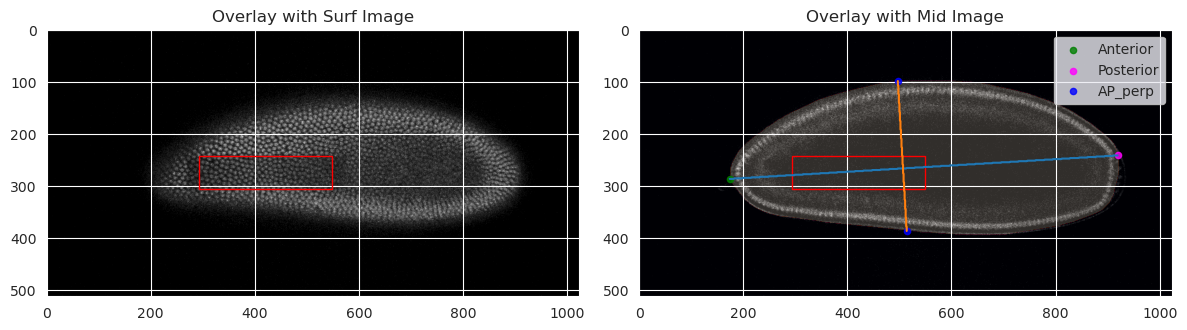

Save compiled dataframe
Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-15/MCP-mSG_His-RFP_Var2(001)_embryo01
Reading previous imported dataset
Reading previous imported FullEmbryo dataset


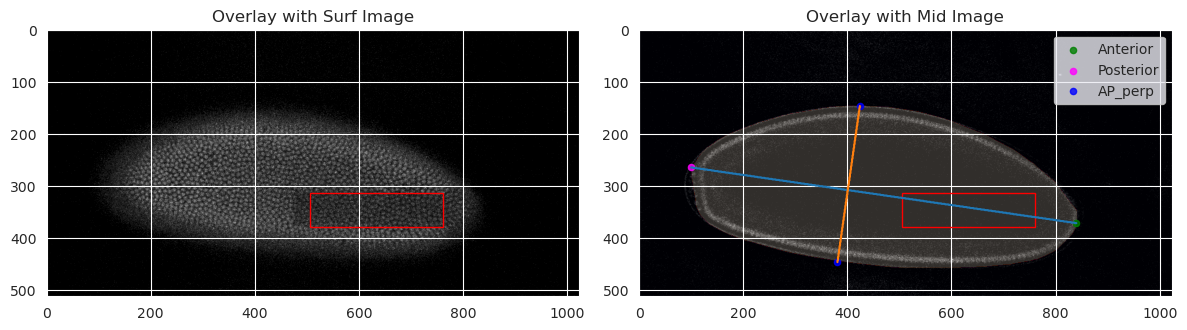

Save compiled dataframe


In [11]:
    for i in range(len(embryo_list)):
        # Define the dataset path
        test_dataset_name = dataset_folder + embryo_list[i]
        print('Dataset Path: ' + test_dataset_name)
        # Load the dataset
        dataset = import_dataset(test_dataset_name)

        # Load the full embryo dataset
        FullEmbryo_dataset = import_fullEmbryo_dataset(test_dataset_name)

        # Load spot tracking
        spot_tracking = spot_pipeline.Spot()
        spot_tracking.read_results(name_folder=test_dataset_name)
        # Load spot tracking dataframe
        spot_df = spot_tracking.spot_dataframe

        # Remove spots that were not detected
        detected_spots = spot_df[spot_df["particle"] != 0]

        # Compile traces
        compiled_dataframe = compile_data.compile_traces(
            detected_spots,
            compile_columns_spot=[
                "frame",
                "t_s",
                "intensity_from_neighborhood",
                "intensity_std_error_from_neighborhood",
                "x",
                "y"
            ],
            nuclear_tracking_dataframe=None,
        )
        # Load the full embryo dataset
        fullEmbryo = fullEmbryo_pipeline.FullEmbryo(FullEmbryo_dataset, dataset, his_channel=nuclear_channel)
        fullEmbryo.find_ap_axis(make_plots=True, remove_small_objects=False, ap_method='maxf', sigma=10, radius=5)

        # Create compiled dataframe
        compiled_dataframe = fullEmbryo.xy_to_ap(compiled_dataframe)
        # Save compiled dataframe
        print('Save compiled dataframe')
        compiled_dataframe.to_pickle(test_dataset_name + '/compiled_dataframe.pkl')
